In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from scipy.stats import levene
from utils import smooth
plt.style.use('default')

In [2]:
# Some conventions used for naming result files
envs = ['grid_world', 'cart_pole']
methods = ['no_baseline_', 'learned_baseline', 'SC_baseline']
stochasticity = ['0.0', '0.15', '0.3']

In [3]:
# Load results for Method-1
method_1_file_name = f'./{envs[1]}_evaluations/s{stochasticity[0]}_{methods[0]}.pkl'
method_1 = pickle.load(open(method_1_file_name, 'rb'))
print(f'Method-1 File name: {method_1_file_name}')

# Load results for Method-2
method_2_file_name = f'./{envs[1]}_evaluations/s{stochasticity[0]}_{methods[1]}.pkl'
method_2 = pickle.load(open(method_2_file_name, 'rb'))
print(f'Method-2 File name: {method_2_file_name}')

Method-1 File name: ./cart_pole_evaluations/s0.0_no_baseline_.pkl
Method-2 File name: ./cart_pole_evaluations/s0.0_learned_baseline.pkl


In [4]:
# Pre-processing of results
method_1_results = method_1['episode_durations']
method_1_results = np.asarray(method_1_results)

method_2_results = method_2['episode_durations']
method_2_results = np.asarray(method_2_results)

# We need to compare both mean and variance of two methods
# For mean we will take mean of last N steps for each run as to get metric of performance in that run
N = 50
# Sufficient statistic from method-1 results
suff_statistic_method_1 = method_1_results[:,-1*N:].mean(axis=1)
suff_statistic_method_2 = method_2_results[:,-1*N:].mean(axis=1)

In [5]:
# Significance testing between mean performance of method-1 and method-2
ttest_pvalue = ttest_ind(suff_statistic_method_1, suff_statistic_method_2)[1]
print(ttest_pvalue)

0.03252681829397809


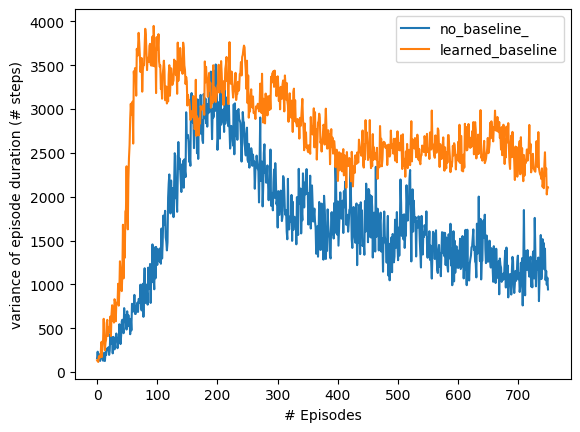

In [6]:
# plot of variance of method-1 and method-2 as a function of epochs
method_1_var = method_1_results.var(axis=0)
method_2_var = method_2_results.var(axis=0)

plt.plot(method_1_var, label=methods[0])
plt.plot(method_2_var, label=methods[1])
plt.legend()
plt.xlabel('# Episodes')
plt.ylabel('variance of episode duration (# steps)')
plt.savefig(f'plots/{envs[0]}_s_{stochasticity[0]}_{methods[0]}_vs_{methods[1]}.jpeg')
plt.show()

In [7]:
# Significance testing between variance of method-1 and method-2
levenes_test_pvalue = levene(suff_statistic_method_1, suff_statistic_method_2)[1]
print(levenes_test_pvalue)

0.0010081170795343368


In [16]:
def run_significance_testing(env, methods, stoch):
    # Load results for Method-1
    method_1_file_name = f'./{env}_evaluations/s{stoch}_{methods[0]}.pkl'
    method_1 = pickle.load(open(method_1_file_name, 'rb'))
    print(f'Method-1 File name: {method_1_file_name}')

    # Load results for Method-2
    method_2_file_name = f'./{env}_evaluations/s{stoch}_{methods[1]}.pkl'
    method_2 = pickle.load(open(method_2_file_name, 'rb'))
    print(f'Method-2 File name: {method_2_file_name}')
        
    # Load results for Method-3
    method_3_file_name = f'./{env}_evaluations/s{stoch}_{methods[2]}.pkl'
    method_3 = pickle.load(open(method_3_file_name, 'rb'))
    print(f'Method-3 File name: {method_3_file_name}')
    
    # Pre-processing of results
    method_1_results = method_1['episode_durations']
    method_1_results = np.asarray(method_1_results)
    method_2_results = method_2['episode_durations']
    method_2_results = np.asarray(method_2_results)
    method_3_results = method_3['episode_durations']
    method_3_results = np.asarray(method_3_results)
    
    # We need to compare both mean and variance of two methods
    # For mean we will take mean of last N steps for each run as to get metric of performance in that run
    N = 50
    
    # Sufficient statistic from method-1 results
    suff_statistic = {
        methods[0]: method_1_results[:,-N:].mean(axis=1),
        methods[1]: method_2_results[:,-N:].mean(axis=1),
        methods[2]: method_3_results[:,-N:].mean(axis=1)
    }
    
    names = {
        methods[0]: 'No Baseline',
        methods[1]: 'Learned Baseline',
        methods[2]: 'Self-Critic Baseline'
    }

    colors = {
        methods[0]: 'r',
        methods[1]: 'g',
        methods[2]: 'b'
    }

    # smoothing factor
    sm = 5
    
    # plot of variance of methods as a function of epochs
    method_1_var = smooth(method_1_results.var(axis=0), sm)
    method_2_var = smooth(method_2_results.var(axis=0), sm)
    method_3_var = smooth(method_3_results.var(axis=0), sm)
    
    plt.plot(method_1_var, label=names[methods[0]])
    plt.plot(method_2_var, label=names[methods[1]])
    plt.plot(method_3_var, label=names[methods[2]])
    plt.legend(loc='lower right')
    plt.xlabel('# Episodes')
    plt.ylabel('variance of episode duration (# steps)')
    # plt.ylim(top=80)
    plt.savefig(f'plots/var_{env}_s_{stoch}{"_smoothed" if sm > 1 else ""}.png')
    plt.show()

    # plot of std deviations of methods as a function of epochs
    method_1_sd = smooth(method_1_results.std(axis=0), sm)
    method_2_sd = smooth(method_2_results.std(axis=0), sm)
    method_3_sd = smooth(method_3_results.std(axis=0), sm)
    
    plt.plot(method_1_sd, label=names[methods[0]])
    plt.plot(method_2_sd, label=names[methods[1]])
    plt.plot(method_3_sd, label=names[methods[2]])
    plt.legend(loc='lower right')
    plt.xlabel('# Episodes')
    plt.ylabel('SD of episode duration (# steps)')
    plt.ylim(top=80)
    plt.savefig(f'plots/sd_{env}_s_{stoch}{"_smoothed" if sm > 1 else ""}.png')
    plt.show()
    
    # plot of mean of runs of methods as a function of epochs
    method_1_mean = smooth(method_1_results.mean(axis=0), sm)
    method_2_mean = smooth(method_2_results.mean(axis=0), sm)
    method_3_mean = smooth(method_3_results.mean(axis=0), sm)

    plt.plot(method_1_mean, label=names[methods[0]])
    plt.plot(method_2_mean, label=names[methods[1]])
    plt.plot(method_3_mean, label=names[methods[2]])
    plt.legend(loc='lower right')
    plt.xlabel('# Episodes')
    plt.ylabel('mean of episode duration (# steps)')
    plt.ylim(top=200)
    plt.savefig(f'plots/mean_{env}_s_{stoch}{"_smoothed" if sm > 1 else ""}.png')
    plt.show()

    # plot of mean and SD (error bars) runs of methods as a function of epochs
    # plt.plot(method_1_mean, label=names[methods[0]], color=colors[methods[0]])
    # plt.fill_between(range(len(method_1_mean)), method_1_mean - method_1_sd, method_1_mean + method_1_sd, 
    # color=colors[methods[0]], alpha=0.2)
    # plt.plot(method_2_mean, label=names[methods[1]], color=colors[methods[1]])
    # plt.fill_between(range(len(method_2_mean)), method_2_mean - method_2_sd, method_2_mean + method_2_sd, 
    # color=colors[methods[1]], alpha=0.2)
    # plt.plot(method_3_mean, label=names[methods[2]], color=colors[methods[2]])
    # plt.fill_between(range(len(method_3_mean)), method_3_mean - method_3_sd, method_3_mean + method_3_sd, 
    # color=colors[methods[2]], alpha=0.2)
    # plt.legend(loc='lower right')
    # plt.xlabel('# Episodes')
    # plt.ylabel('mean of episode duration (# steps)')
    # plt.ylim(top=200)
    # plt.savefig(f'plots/mean_{env}_s_{stoch}.png')
    # plt.show()
    
    significance_var = np.ndarray(shape=(3, 3))
    significance_mean = np.ndarray(shape=(3, 3))
    for i,meth_1 in enumerate(methods):
        for j,meth_2 in enumerate(methods):
            # Significance testing between mean performance of method-1 and method-2
            ttest_pvalue = ttest_ind(suff_statistic[meth_1], suff_statistic[meth_2])[1]
            significance_var[i][j] = ttest_pvalue
    
            # Significance testing between variance of method-1 and method-2
            levenes_test_pvalue = levene(suff_statistic[meth_1], suff_statistic[meth_2])[1]
            significance_mean[i][j] = ttest_pvalue
    
    print(f'variance significance table:\n{significance_var}')
    print()
    print(f'mean significance table:\n{significance_mean}')
    print()
    print()
    with open(f'results/{env}_{stoch}.txt', 'w+') as f:
        f.write('variance significance table:\n')
        np.savetxt(f, significance_var)
        f.write('mean significance table:\n')
        np.savetxt(f, significance_mean)

Method-1 File name: ./cart_pole_evaluations/s0.0_no_baseline_.pkl
Method-2 File name: ./cart_pole_evaluations/s0.0_learned_baseline.pkl
Method-3 File name: ./cart_pole_evaluations/s0.0_SC_baseline.pkl
variance significance table:
[[1.         0.03252682 0.63149466]
 [0.03252682 1.         0.06683623]
 [0.63149466 0.06683623 1.        ]]

mean significance table:
[[1.         0.03252682 0.63149466]
 [0.03252682 1.         0.06683623]
 [0.63149466 0.06683623 1.        ]]


Method-1 File name: ./cart_pole_evaluations/s0.15_no_baseline_.pkl
Method-2 File name: ./cart_pole_evaluations/s0.15_learned_baseline.pkl
Method-3 File name: ./cart_pole_evaluations/s0.15_SC_baseline.pkl
variance significance table:
[[1.00000000e+00 1.15814460e-12 4.24789056e-03]
 [1.15814460e-12 1.00000000e+00 1.15982395e-05]
 [4.24789056e-03 1.15982395e-05 1.00000000e+00]]

mean significance table:
[[1.00000000e+00 1.15814460e-12 4.24789056e-03]
 [1.15814460e-12 1.00000000e+00 1.15982395e-05]
 [4.24789056e-03 1.15982

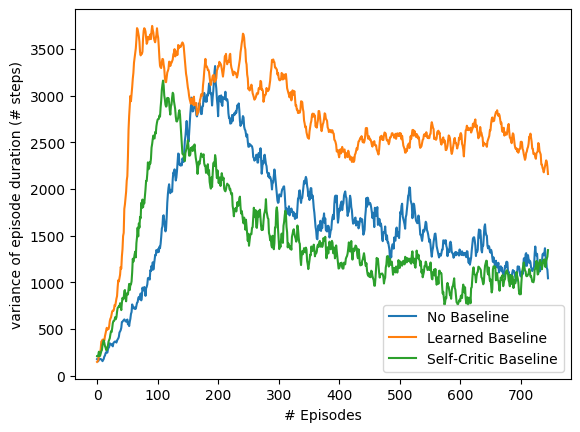

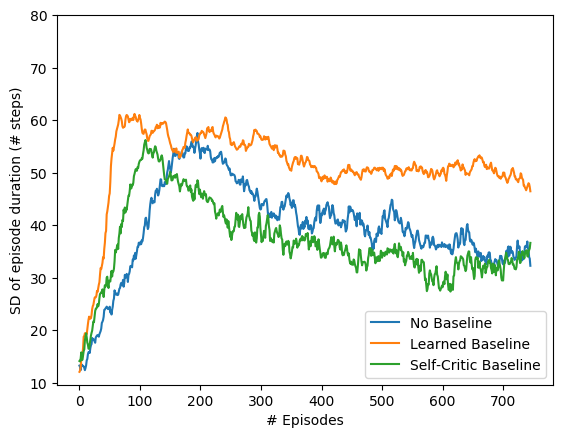

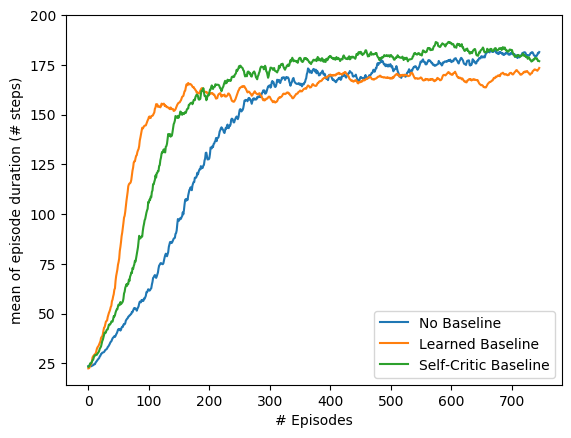

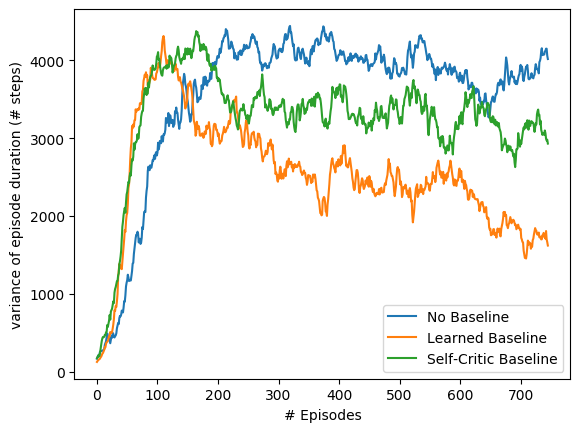

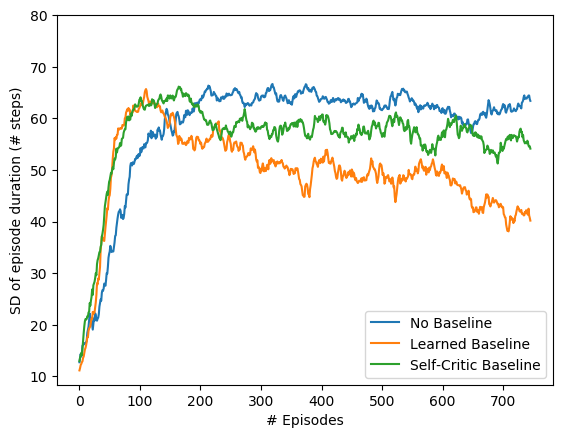

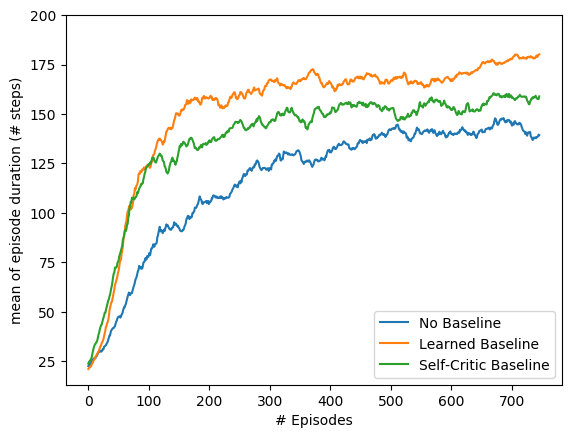

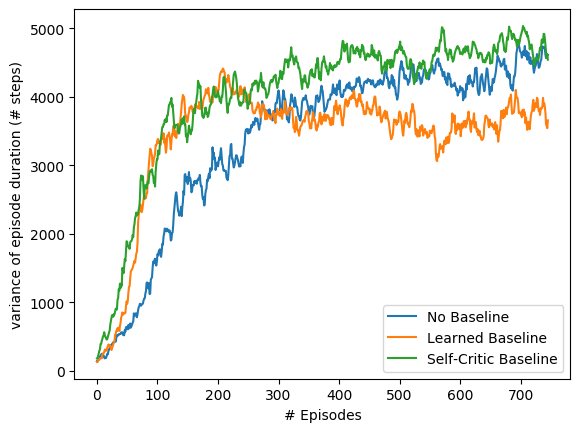

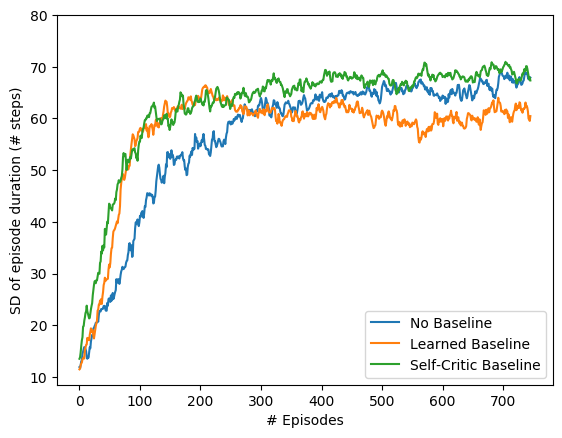

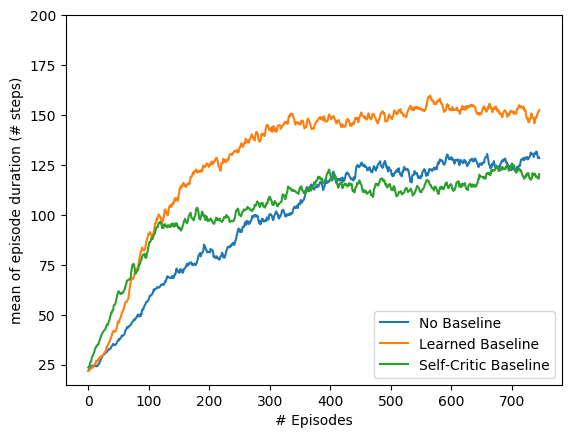

In [17]:
for env in [envs[1]]:
    for stoch in stochasticity:
        run_significance_testing(env, methods, stoch)

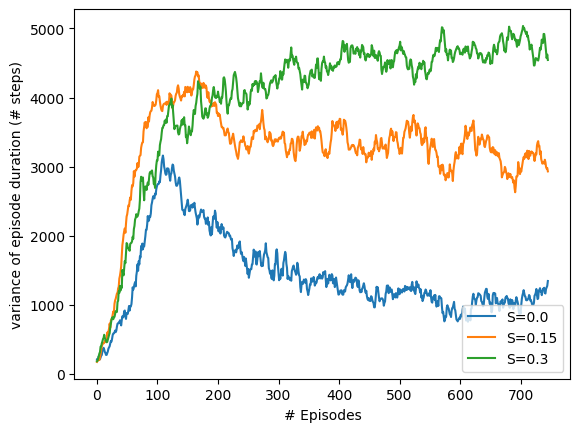

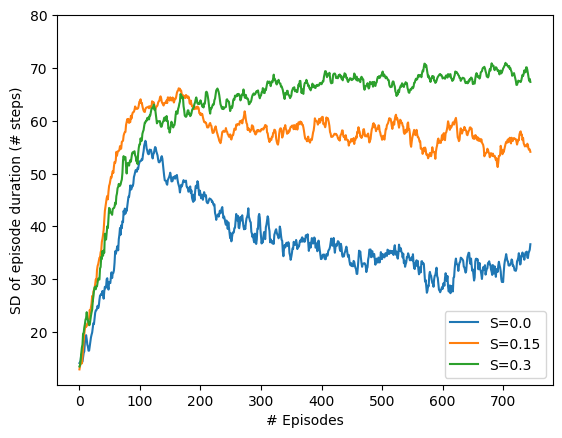

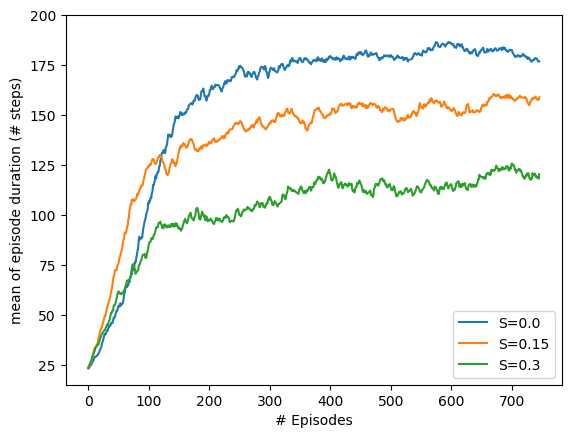

In [13]:
var = {}
sd = {}
mean = {}

# smoothing factor
sm = 5

for stoch in stochasticity:
    method_1_file_name = f'./{env}_evaluations/s{stoch}_{methods[2]}.pkl'
    method_1 = pickle.load(open(method_1_file_name, 'rb'))
    method_1_results = method_1['episode_durations']
    method_1_results = np.asarray(method_1_results)
    
    var[stoch] = smooth(method_1_results.var(axis=0), sm)
    sd[stoch] = smooth(method_1_results.std(axis=0), sm)
    mean[stoch] = smooth(method_1_results.mean(axis=0), sm)

plt.plot(var[stochasticity[0]], label=f'S={stochasticity[0]}')
plt.plot(var[stochasticity[1]], label=f'S={stochasticity[1]}')
plt.plot(var[stochasticity[2]], label=f'S={stochasticity[2]}')
plt.legend(loc='lower right')
plt.xlabel('# Episodes')
plt.ylabel('variance of episode duration (# steps)')
plt.savefig(f'plots/var_{env}_SC_baseline{"_smoothed" if sm > 1 else ""}.png')
plt.show()

plt.plot(sd[stochasticity[0]], label=f'S={stochasticity[0]}')
plt.plot(sd[stochasticity[1]], label=f'S={stochasticity[1]}')
plt.plot(sd[stochasticity[2]], label=f'S={stochasticity[2]}')
plt.legend(loc='lower right')
plt.xlabel('# Episodes')
plt.ylabel('SD of episode duration (# steps)')
plt.ylim(top=80)
plt.savefig(f'plots/sd_{env}_SC_baseline{"_smoothed" if sm > 1 else ""}.png')
plt.show()

plt.plot(mean[stochasticity[0]], label="S=" + stochasticity[0])
plt.plot(mean[stochasticity[1]], label="S=" + stochasticity[1])
plt.plot(mean[stochasticity[2]], label="S=" + stochasticity[2])
plt.legend(loc='lower right')
plt.xlabel('# Episodes')
plt.ylabel('mean of episode duration (# steps)')
plt.ylim(top=200)
plt.savefig(f'plots/mean_{env}_SC_baseline{"_smoothed" if sm > 1 else ""}.png')
plt.show()